In [14]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib

from modules import network,mlp
from utils import yaml_config_hook
from evaluation import evaluation_tools

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [15]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
class_num = args.classnum

In [16]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes

adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
# dataframe.head()

(8569, 2000) (8569, 1)


In [17]:
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [18]:
def find_all_file(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            yield f

In [41]:
def jaccard_index_x(i):
    x_i_index=y_ndarray[y_ndarray==i]
    x_i=x_ndarray[x_i_index]
    print(f'Class {i} shape: {x_i.shape}')
    
    history_index_result=[]

    for step,j in enumerate(list(find_all_file('save\sc-static-bank-rare-swap'))):
        # print(f'Propressing {step} Epoch.....')
        checkpoint=torch.load('save\sc-static-bank-rare-swap\\'+j)
        model.load_state_dict(checkpoint['net'])
        x=torch.tensor(x_i,dtype=torch.float32).to('cuda')
        embeddings=model.forward_embedding(x)
        embeddings=embeddings.detach().cpu().numpy()
        index=hnswlib.Index(space='cosine',dim=128)
        index.init_index(max_elements=len(embeddings), ef_construction=200, M=16)
        index.set_ef(200)
        index.set_num_threads(4)
        index.add_items(embeddings)

        labels,distances=index.knn_query(embeddings,k=11)
        history_index_result.append(labels)
        # previous_embedding=embeddings
        # if step>=10:
        #     break

    history_index_result=np.array(history_index_result)

    jaccard_index_i=[]
    for j in np.arange(1,200):
        intersect=0
        union=0
        for label_1,label_2 in zip(history_index_result[j],history_index_result[j-1]):
            intersect+=len(np.intersect1d(label_1,label_2))
            union+=len(np.union1d(label_1,label_2))
        jaccard_index_i.append(intersect/union)
        
    return jaccard_index_i

In [20]:
import pandas as pd
array_data=np.array([jaccard_index_x(1),jaccard_index_x(2),jaccard_index_x(3),jaccard_index_x(4),jaccard_index_x(5),jaccard_index_x(6),jaccard_index_x(7),jaccard_index_x(8),jaccard_index_x(9),jaccard_index_x(10),jaccard_index_x(11),jaccard_index_x(12),jaccard_index_x(13)])
row_indices=['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9','Class 10','Class 11','Class 12','Class 13']
column_names=np.arange(1,201)

Class 1 shape: (958, 2000)
Class 2 shape: (284, 2000)
Class 3 shape: (2326, 2000)
Class 4 shape: (2525, 2000)
Class 5 shape: (601, 2000)
Class 6 shape: (1077, 2000)
Class 7 shape: (252, 2000)
Class 8 shape: (18, 2000)
Class 9 shape: (255, 2000)
Class 10 shape: (55, 2000)
Class 11 shape: (25, 2000)
Class 12 shape: (173, 2000)
Class 13 shape: (13, 2000)


In [21]:
data=pd.DataFrame(array_data,index=row_indices).T

In [22]:
data.head()

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,Class 10,Class 11,Class 12,Class 13
0,0.052905,0.064758,0.049768,0.049737,0.055902,0.052272,0.068826,0.511450,0.068571,0.128731,0.328502,0.077882,0.743902
1,0.052852,0.063670,0.049488,0.049698,0.054470,0.051898,0.070064,0.477612,0.064920,0.157895,0.273148,0.080636,0.733333
2,0.052958,0.062947,0.049617,0.049361,0.054722,0.051711,0.066154,0.511450,0.070406,0.143667,0.300236,0.080943,0.754601
3,0.053273,0.067669,0.049962,0.049380,0.055986,0.052833,0.062883,0.409253,0.066946,0.155683,0.264368,0.073928,0.722892
4,0.053221,0.064758,0.049510,0.049043,0.057083,0.051571,0.067591,0.500000,0.065527,0.163462,0.354680,0.076967,0.754601


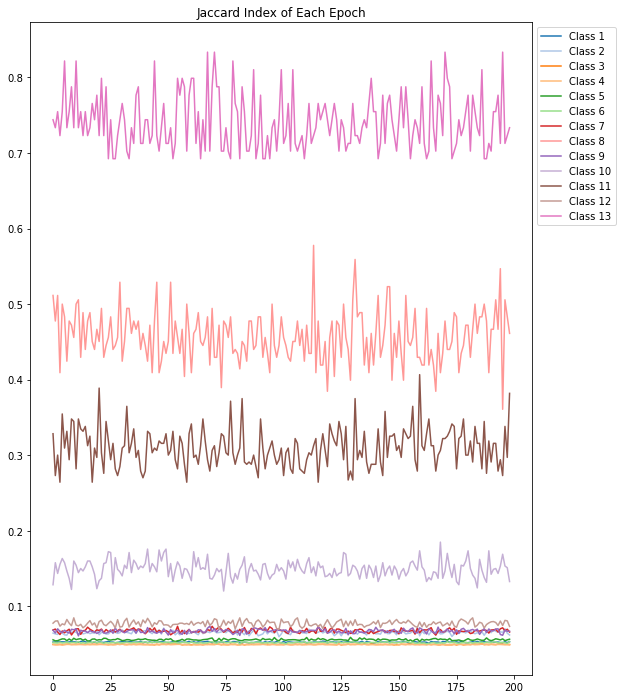

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,12))
palette_0 = sns.color_palette("tab20", 13)
ax=sns.lineplot(data=data, palette=palette_0,dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title('Jaccard Index of Each Epoch')
# plt.xlabel('Epoch')
# plt.figure(figsize=(12,6))
# plt.title('Jaccaed Index')
# plt.legend()
plt.show()

In [24]:
def nn_distance(i):
    x_i_index=y_ndarray[y_ndarray==i]
    x_i=x_ndarray[x_i_index]
    print(f'Class {i} shape: {x_i.shape}')
    
    nn_distance=[]

    for step,j in enumerate(list(find_all_file('save\sc-static-bank-rare-swap'))):
        # print(f'Propressing {step} Epoch.....')
        if step % 3 ==0:
            checkpoint=torch.load('save\sc-static-bank-rare-swap\\'+j)
            model.load_state_dict(checkpoint['net'])
            x=torch.tensor(x_i,dtype=torch.float32).to('cuda')
            embeddings=model.forward_embedding(x)
            embeddings=embeddings.detach().cpu().numpy()
            index=hnswlib.Index(space='cosine',dim=128)
            index.init_index(max_elements=len(embeddings), ef_construction=100, M=16)
            index.set_ef(100)
            index.set_num_threads(4)
            index.add_items(embeddings)

            labels,distances=index.knn_query(embeddings,k=11)
            nn_distance.append(distances)
            # previous_embedding=embeddings
            # if step>=10:
            #     break

    nn_distance=np.array(nn_distance)
    nn_distance=np.mean(nn_distance,axis=0)
    nn_distance=np.mean(nn_distance,axis=0)
    
    # nn_distance=np.mean(nn_distance,axis=1)

    return nn_distance

In [54]:
array_data=np.array([nn_distance(1),nn_distance(2),nn_distance(3),nn_distance(4),nn_distance(5),nn_distance(6),nn_distance(7),nn_distance(8),nn_distance(9),nn_distance(10),nn_distance(11),nn_distance(12),nn_distance(13)])
row_indices=['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9','Class 10','Class 11','Class 12','Class 13']
column_names=np.arange(1,201)

Class 1 shape: (958, 2000)
Class 2 shape: (284, 2000)
Class 3 shape: (2326, 2000)
Class 4 shape: (2525, 2000)
Class 5 shape: (601, 2000)
Class 6 shape: (1077, 2000)
Class 7 shape: (252, 2000)
Class 8 shape: (18, 2000)
Class 9 shape: (255, 2000)
Class 10 shape: (55, 2000)
Class 11 shape: (25, 2000)
Class 12 shape: (173, 2000)
Class 13 shape: (13, 2000)


Text(0.5, 0, 'Cell Class')

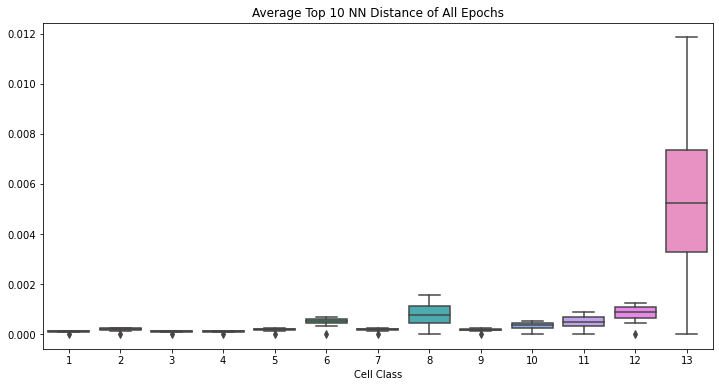

In [55]:
data=pd.DataFrame(array_data,index=np.arange(1,14)).T
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
import seaborn as sns
ax=sns.boxplot(data=data)
ax.set_title('Average Top 10 NN Distance of All Epochs')
ax.set_xlabel('Cell Class')

In [56]:
data=pd.DataFrame(array_data[0:12],index=np.arange(1,13)).T

Text(0.5, 0, 'Cell Class')

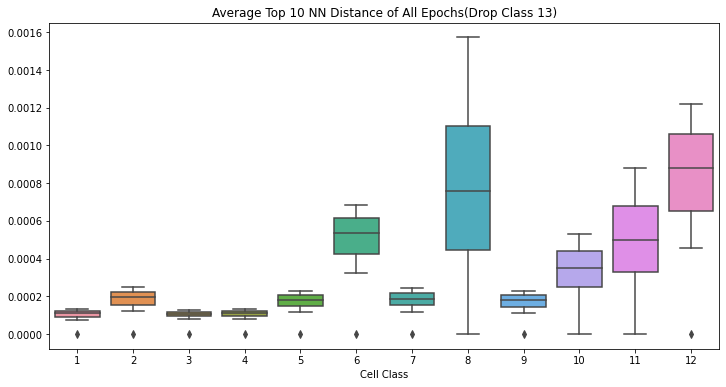

In [57]:
plt.figure(figsize=(12,6))
ax=sns.boxplot(data=data)
ax.set_title('Average Top 10 NN Distance of All Epochs(Drop Class 13)')
ax.set_xlabel('Cell Class')

In [59]:
def nn_distance_epoch(i):
    x_i_index=y_ndarray[y_ndarray==i]
    x_i=x_ndarray[x_i_index]
    print(f'Class {i} shape: {x_i.shape}')
    
    nn_distance=[]
    # steps=[]

    for step,j in enumerate(list(find_all_file('save\sc-static-bank-rare-swap'))):
        # print(f'Propressing {step} Epoch.....')
        if step % 3 ==0:
            # print(step+1)
            checkpoint=torch.load('save\sc-static-bank-rare-swap\\'+j)
            model.load_state_dict(checkpoint['net'])
            x=torch.tensor(x_i,dtype=torch.float32).to('cuda')
            embeddings=model.forward_embedding(x)
            embeddings=embeddings.detach().cpu().numpy()
            index=hnswlib.Index(space='cosine',dim=128)
            index.init_index(max_elements=len(embeddings), ef_construction=100, M=16)
            index.set_ef(100)
            index.set_num_threads(4)
            index.add_items(embeddings)

            labels,distances=index.knn_query(embeddings,k=11)
            nn_distance.append(distances)
            # previous_embedding=embeddings
            # if step>=10:
            #     break

    nn_distance=np.array(nn_distance)
    nn_distance=np.mean(nn_distance,axis=1)

    
    # nn_distance=np.mean(nn_distance,axis=1)

    return nn_distance

In [51]:
nn_distance_epoch(8).shape

Class 8 shape: (18, 2000)
1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
82
85
88
91
94
97
100
103
106
109
112
115
118
121
124
127
130
133
136
139
142
145
148
151
154
157
160
163
166
169
172
175
178
181
184
187
190
193
196
199


(67, 11)

In [94]:
array_data=np.array([nn_distance_epoch(1),nn_distance_epoch(2),nn_distance_epoch(3),nn_distance_epoch(4),nn_distance_epoch(5),nn_distance_epoch(6),nn_distance_epoch(7),nn_distance_epoch(8),nn_distance_epoch(9),nn_distance_epoch(10),nn_distance_epoch(11),nn_distance_epoch(12),nn_distance_epoch(13)])


Class 1 shape: (958, 2000)
Class 2 shape: (284, 2000)
Class 3 shape: (2326, 2000)
Class 4 shape: (2525, 2000)
Class 5 shape: (601, 2000)
Class 6 shape: (1077, 2000)
Class 7 shape: (252, 2000)
Class 8 shape: (18, 2000)
Class 9 shape: (255, 2000)
Class 10 shape: (55, 2000)
Class 11 shape: (25, 2000)
Class 12 shape: (173, 2000)
Class 13 shape: (13, 2000)


In [32]:
array_data.shape

(13, 67, 11)

In [86]:
data_13=nn_distance_epoch(13)
# data_13=pd.DataFrame(data_13)
print(data_13.shape)

Class 13 shape: (13, 2000)
(67, 11)


In [87]:
data_1=data_13[-1]
data_2=data_13[-10]
data_3=data_13[-20]
data_4=data_13[-30]
data_5=data_13[-40]
data_6=data_13[-50]
data_7=data_13[-60]
data_8=data_13[0]
data_13=pd.DataFrame(data=np.array([data_8,data_7,data_6,data_5,data_4,data_3,data_2,data_1]),index=[1,22,52,82,112,142,172,199]).T

Text(0.5, 1.0, 'Average Top 10 NN Distance of Cell Class 13')

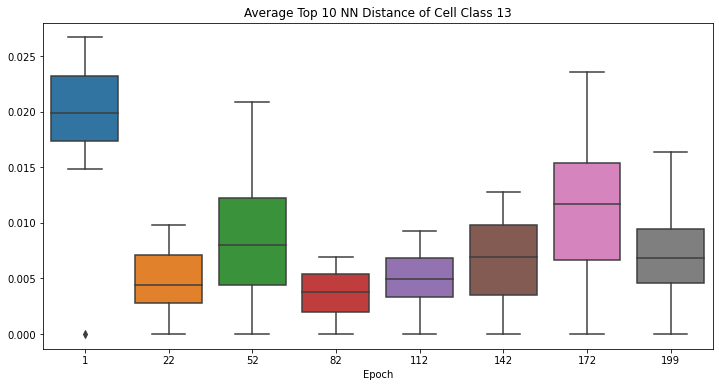

In [91]:
plt.figure(figsize=(12,6))
ax=sns.boxplot(data=data_13)
ax.set_xlabel('Epoch')
ax.set_title('Average Top 10 NN Distance of Cell Class 13')

In [95]:
column_names=np.arange(1,14)
data_1=pd.DataFrame(data=array_data[0:12,-1,:],index=column_names[0:12]).T
data_2=pd.DataFrame(data=array_data[0:12,-10,:],index=column_names[0:12]).T
data_3=pd.DataFrame(data=array_data[0:12,-20,:],index=column_names[0:12]).T
data_4=pd.DataFrame(data=array_data[0:12,-30,:],index=column_names[0:12]).T
data_5=pd.DataFrame(data=array_data[0:12,-40,:],index=column_names[0:12]).T
data_6=pd.DataFrame(data=array_data[0:12,-50,:],index=column_names[0:12]).T
data_7=pd.DataFrame(data=array_data[0:12,-60,:],index=column_names[0:12]).T
data_8=pd.DataFrame(data=array_data[0:12,0,:],index=column_names[0:12]).T

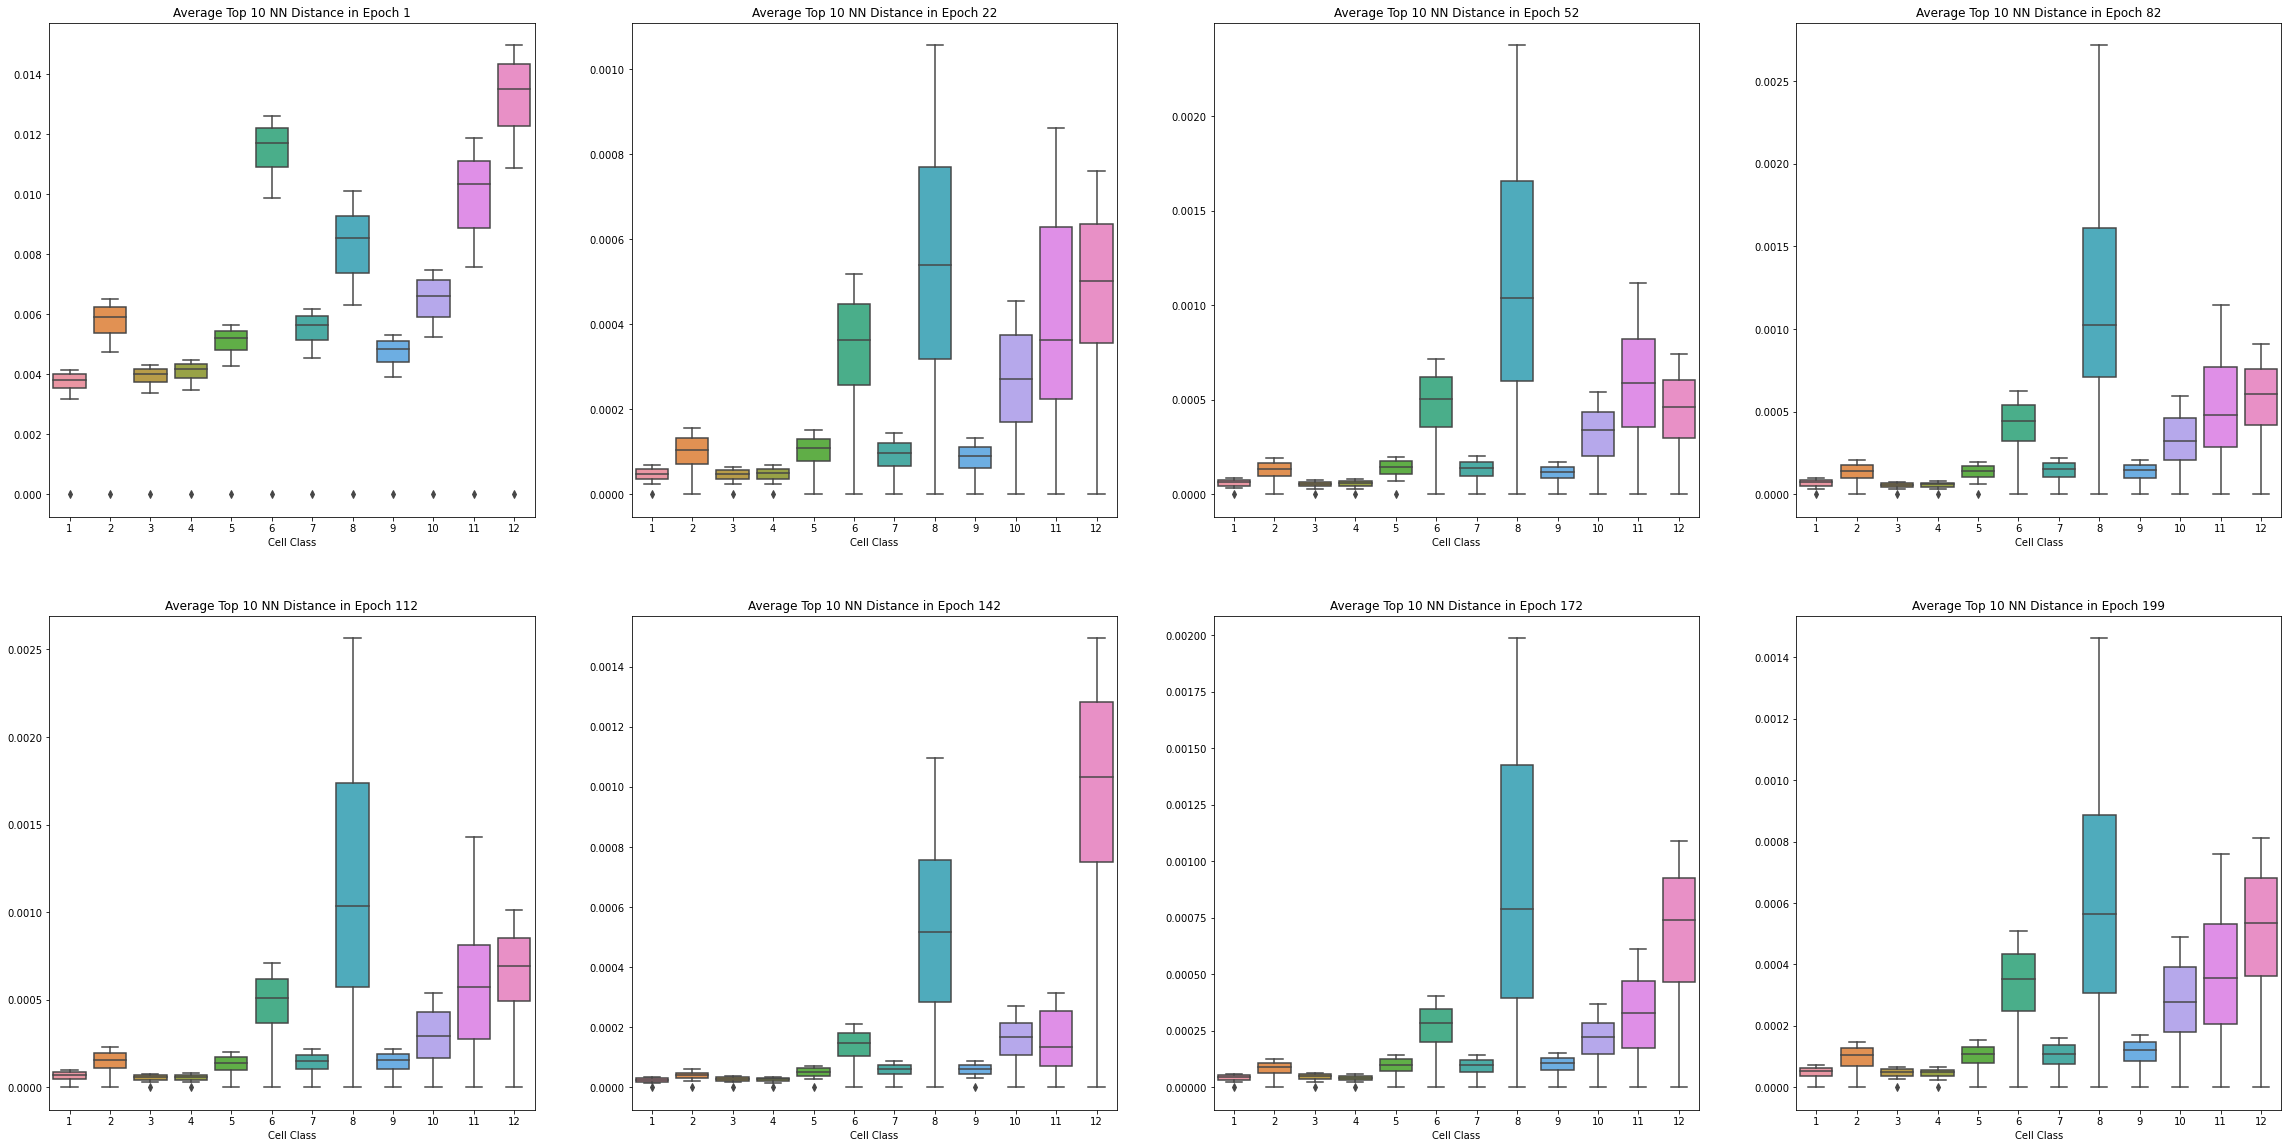

In [97]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
axs = sns.boxplot(data=data_8,ax=ax[0][0])
axs.set_title('Average Top 10 NN Distance in Epoch 1')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_7,ax=ax[0][1])
axs.set_title('Average Top 10 NN Distance in Epoch 22')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_6,ax=ax[0][2])
axs.set_title('Average Top 10 NN Distance in Epoch 52')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_5,ax=ax[0][3])
axs.set_title('Average Top 10 NN Distance in Epoch 82')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_4,ax=ax[1][0])
axs.set_title('Average Top 10 NN Distance in Epoch 112')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_3,ax=ax[1][1])
axs.set_title('Average Top 10 NN Distance in Epoch 142')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_2,ax=ax[1][2])
axs.set_title('Average Top 10 NN Distance in Epoch 172')
axs.set_xlabel('Cell Class')
axs = sns.boxplot(data=data_1,ax=ax[1][3])
axs.set_title('Average Top 10 NN Distance in Epoch 199')
axs.set_xlabel('Cell Class')

plt.show()